In [4]:
import os 
import numpy as np 
from PIL import Image 
import torch 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
import utils
import random
import matplotlib.pyplot as plt
%matplotlib inline 

In [11]:
class SiemeseDataset(Dataset):
    def __init__(self, image_paths, labels, image_transform=transforms.ToTensor(), display_transform=None, convert="L"):
        super().__init__()
        image_paths = np.asarray([x.replace("\n", "") for x in image_paths])
        self.transforms = image_transform
        self.display = display_transform 
        self.convert = convert
        assert image_paths.shape[0] == labels.shape[0]

        # create dictionary to make creating pairs easier 
        self.data = {}
        for i in range(len(labels)):
            if labels[i] not in self.data.keys(): 
                self.data[labels[i]] = [image_paths[i]]
            else:
                self.data[labels[i]].append(image_paths[i])
        self.n_classes = len(self.data.keys())
        self.class_list = list(self.data.keys())
        self.len = image_paths.shape[0]
    def __len__(self):
        return self.len
    
    def convert_img(self, img_path, disp=False):
        img = Image.open(img_path).convert(self.convert)
        if disp:
            img = self.display(img)
        else:
            img = self.transforms(img)
        return img 
    
    def __getitem__(self, ix):
        label = None 
        img1 = None
        img2 = None 
        
        # get image from same class
        if ix % 2 == 1:
            label = 1
            idx1 = random.choice(self.class_list)
            img_path1 = random.choice(self.data[idx1])
            img_path2 = random.choice(self.data[idx1])
        # get image from another class
        else:
            label = 0
            idx1 = random.choice(self.class_list)
            idx2 = random.choice(self.class_list)
            while idx1 == idx2:
                idx2 = random.choice(self.class_list)
            img_path1 = random.choice(self.data[idx1])
            img_path2 = random.choice(self.data[idx2])
       
        image1 = self.convert_img(img_path1)
        image2 = self.convert_img(img_path2)
         
        if self.display != None: 
            disp_img1 = self.convert_img(img_path1, disp=True)
            disp_img2 = self.convert_img(img_path2, disp=True)
            return image1, image2, label, disp_img1, disp_img2
        return image1, image2, label 
    

In [12]:
data_dir = "../../siemese_data"
txt_fname = "data.txt"

file_contents = utils.process_txt(os.path.join(data_dir, txt_fname))
img_paths = []
labels = []
for label, fname in file_contents:
    img_paths.append(os.path.join(data_dir, label, fname))
    labels.append(label)

# create a classes dict automatically from labels 
siemese_classes_dict = {}
key = 0 
for label in labels: 
    if label not in siemese_classes_dict.keys():
        siemese_classes_dict[label] = key
        key += 1

img_paths = np.asarray(img_paths)
labels = np.asarray([siemese_classes_dict[x] for x in labels])


In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
img_transform = transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128),
                                            transforms.ToTensor()]) 

dataset = SiemeseDataset(img_paths, labels, image_transform=img_transform)

In [14]:
image1, image2, label = dataset.__getitem__(0)
print(image1.shape)
print(image2.shape)
print(label)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
0


In [15]:
image1, image2, label = dataset.__getitem__(1)
print(image1.shape)
print(image2.shape)
print(label)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
1


In [16]:
image1, image2, label = dataset.__getitem__(2)
print(image1.shape)
print(image2.shape)
print(label)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
0


In [17]:
# now let's create a dataset with display transforms, to verify correctness visually 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
img_transform = transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128),
                                            transforms.ToTensor()]) 
display_transform = transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128)])

dataset = SiemeseDataset(img_paths, labels, image_transform=img_transform, display_transform=display_transform)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
0


(-0.5, 127.5, 127.5, -0.5)

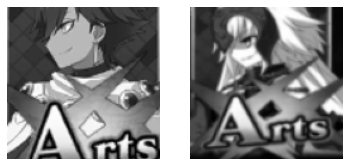

In [26]:
image1, image2, label, disp_img1, disp_img2 = dataset.__getitem__(0)
print(image1.shape)
print(image2.shape)
print(label)

plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(disp_img1, cmap="gray")
plt.axis("off")
ax = plt.subplot(1,2,2)
plt.imshow(disp_img2, cmap="gray")
plt.axis("off")

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])
1


(-0.5, 127.5, 127.5, -0.5)

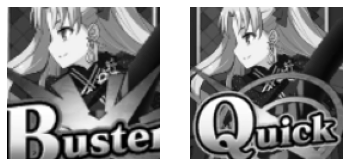

In [19]:
image1, image2, label, disp_img1, disp_img2 = dataset.__getitem__(1)
print(image1.shape)
print(image2.shape)
print(label)

plt.figure()
ax = plt.subplot(1,2,1)
plt.imshow(disp_img1, cmap="gray")
plt.axis("off")
ax = plt.subplot(1,2,2)
plt.imshow(disp_img2, cmap="gray")
plt.axis("off")

In [12]:
class SiemeseDataHandler:
    """
    Helper class which parses a Siemese dataset and returns dataloaders for classification model training.
    First iteration does not include a testing set.
    """
    def __init__(self, data_dir, txt_fname="data.txt", val_split=0.1, seed=11, verbose=True):
        self.verbose = verbose 
        self.val_split = val_split

        file_contents = utils.process_txt(os.path.join(data_dir, txt_fname))
        img_paths = []
        labels = []
        for label, fname in file_contents:
            img_paths.append(os.path.join(data_dir, label, fname))
            labels.append(label)

        # create a classes dict automatically from labels 
        siemese_classes_dict = {}
        key = 0 
        for label in labels: 
            if label not in siemese_classes_dict.keys():
                siemese_classes_dict[label] = key
                key += 1

        img_paths = np.asarray(img_paths)
        labels = np.asarray([siemese_classes_dict[x] for x in labels])

        self.train_img_paths = None
        self.train_labels = None
        self.val_img_paths = None
        self.val_lables = None

        if val_split > 0.0: 
            np.random.seed(seed)

            n_train = int(labels.shape[0] * (1.0 - val_split))
            order = np.random.permutation(labels.shape[0])

            self.val_img_paths = np.asarray(img_paths[order[n_train:]])
            self.val_labels= np.asarray(labels[order[n_train:]])

            self.train_img_paths = np.asarray(img_paths[order[:n_train]])
            self.train_labels = np.asarray(labels[order[:n_train]])
            assert self.val_img_paths.shape[0] == self.val_labels.shape[0]

            if self.verbose:
                print("{} validation split from training".format(self.val_labels.shape[0]))
                print("{} training remains".format(self.train_labels.shape[0]))

        else:
            self.train_img_paths = img_paths
            self.train_labels = img_paths
            
            if self.verbose:
                print("{} training images".format(self.train_labels.shape[0]))

    def get_dataloaders(self, batch_size=16, n_workers=4):
        # note: no data augmentation applied since all cards will be oriented the same way 
        img_transform = transforms.Compose([transforms.Resize(128),
                                            transforms.CenterCrop(128),
                                            transforms.ToTensor(),
                                            normalize])
        trainset = SiemeseDataset(self.train_img_paths, self.train_labels, image_transform=img_transform)

        trainloader = DataLoader(trainset,
                                batch_size=batch_size,
                                shuffle=False,
                                sampler=None,
                                num_workers=n_workers,
                                pin_memory=True)
        valloader = None
        if self.val_split > 0.0:
            valset = SiemeseDataset(self.val_img_paths, self.val_labels, image_transform=img_transform)
            valloader = DataLoader(valset,
                                  batch_size=batch_size, 
                                  shuffle=False,
                                  sampler=None,
                                  num_workers=n_workers, 
                                  pin_memory=True)
        return trainloader, valloader

In [13]:
handler = SiemeseDataHandler(data_dir)

10 validation split from training
83 training remains


In [17]:
trainloader, valloader = handler.get_dataloaders(batch_size=8, n_workers=0)

In [18]:
# check image size, and batch size 
for image1, image2, label in trainloader:
    print(label.shape)
    print(image1.shape)
    print(image2.shape)
    break

torch.Size([8])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


In [19]:
# noice